# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


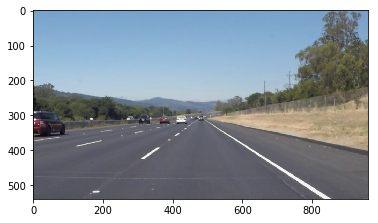

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from scipy.interpolate import interp1d

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[100, 0, 100], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
            
    connect = connect_lines(lines, img.shape)
    
    for line in connect:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def connect_lines(lines, imshape):
    ''' Calculate the slope of the lines while preventing horizontal lines
        and outliers from being drawn in image'''
    lines = np.squeeze(lines) #removing single dimension entries from shape of lines
    x1 = lines[:,0]
    x2 = lines[:,2]
    y1 = lines[:,1]
    y2 = lines[:,3]
    slope = (y2-y1) / (x2-x1) # slope = (y2 - y1)/(x2 - x1) for all values in lines
    line_length = np.sqrt((x2-x1)**2 + (y2-y1)**2)  #calculate length of line using distance formula
    
    slope_cutoff = 0.5
    lines = lines[np.abs(slope)> slope_cutoff] #removes line segments less than the slope cutoff from the array
    line_length = line_length[np.abs(slope)>slope_cutoff]
    slope = slope[np.abs(slope)>slope_cutoff]
    
    #Identify positive and negative slopes and separate line segments based on slope
    lines_right, lines_left = lines[slope>0,:], lines[slope<0,:]
    slope_right, slope_left = slope[slope>0], slope[slope<0]
    line_length_right, line_length_left = line_length[slope>0], line_length[slope<0]
    length_right_sorted = np.argsort(line_length_right)
    length_left_sorted = np.argsort(line_length_left)
    right_X, right_Y = np.concatenate([lines_right[:,0], lines_right[:,2]]), np.concatenate([lines_right[:,1], lines_right[:,3]])
    left_X, left_Y = np.concatenate([lines_left[:,0], lines_left[:,2]]), np.concatenate([lines_left[:,1], lines_left[:,3]])
    
    #average slope of the line segments and calculate intercept

    avg_slope_right, avg_slope_left = slope_right[length_right_sorted][::].mean(), slope_left[length_left_sorted][::].mean()
    
    intercept_right, intercept_left = right_Y - (avg_slope_right * right_X), left_Y - (avg_slope_left * left_X) 
    
    intercept_right = intercept_right[length_right_sorted][::]
    intercept_left = intercept_left[length_left_sorted][::]
    
    avg_intercept_right, avg_intercept_left = np.mean(intercept_right), np.mean(intercept_left)
    
    #define connected line based on averaged values
    y1_both = imshape[0]
    y2_both = 320
    x1_right = (y1_both - avg_intercept_right) / avg_slope_right
    x1_left = (y1_both - avg_intercept_left) / avg_slope_left
    x2_right = (y2_both - avg_intercept_right) / avg_slope_right
    x2_left = (y2_both - avg_intercept_left) / avg_slope_left

    connected_lines = np.array([[[x1_right, y1_both, x2_right, y2_both],[x1_left, y1_both, x2_left, y2_both]]], dtype=np.int32)
    return connected_lines

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Read in image and apply all image transforms
import os

test_images = os.listdir("test_images/")
for img in test_images:
    image = mpimg.imread("test_images/"+img)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 3)
    edges = canny(blur_gray, 50, 150) #low threshold, 3:1 ratio
    
    imshape = image.shape
    #Define Polygon to select area of interest
    vertices = np.array([[(40,imshape[0]),(425, 340), (540, 340), (900,imshape[0])]],dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #Perform Hough Transform and draw onto lines of a blank image
    lines = hough_lines(masked_edges, 1, np.pi/180, 25, 5, 5)
    weight = cv2.cvtColor(weighted_img(lines, image), cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_"+img, weight)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 80, 150) #low threshold = 40, 3:1 ratio

    imshape = image.shape

    #Define Polygon to select area of interest
    vertices = np.array([[(100,imshape[0]),(410, 330), (540, 330), (900,imshape[0])]],dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #Perform Hough Transform and draw onto lines of a blank image
    lines = hough_lines(masked_edges, 1, np.pi/180, 40, 15, 6)
    weight = weighted_img(lines, image)
    # you should return the final output (image where lines are drawn on lanes)
    return weight

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 78.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.24 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:07<00:00, 89.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 7.97 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Project 1 - Finding Lane Lines
### Reflection

#### Pipeline Description

My computer vision pipeline was created using the various techniques to identify lines in an image and selectively display the lane lines of interest. The overarching development process involved writing the code to validate the raw hough lines pipeline on one image, and then extending that method to automatically perform the algorithm on multiple images in the 'test_images' folder.

A test image was read into the program and fed into various transforms. The first step was to convert the image into grayscale and applying a manual gaussian blur function to remove hard linear outliers from following processing. I found that defining the gaussian_blur method with a kernel size of 7 provided the most desirable results. The next step was to employ the Canny Edge theory in order to identify the lines within the image based on pixel color gradients. Simply stated, the Canny Edge detection method finds differences in color between adjacent pixels and identifies large differences as lines.

In order to identify only the lane lines, an image mask was created by defining a polygon such that only the area of interest is selected for processing. In this case, I defined the vertices of a parallelogram by judging the coordinate points (measured in pixels) that encompassed only the areas containing lane lines. The region of interest function fills in pixels only within the defined mask and returns the image only where the pixels are non-zero.

The next step in this process is to remove any "weak lines" that may have been incorrectly detected by the Canny Edge function and identify strong lines as lane lines using a Hough transform. This tranform essentially parameterizes a line in Cartesian space such that a line becomes a point in Hough space. This allows us to identify lines that pass through multiple points (or pixels in our case) in image space as multiple lines intersecting at a single point in Hough space. The hough_lines method essentially allows us to filter out "weak lines" based on the number of intersecting lines, or votes, as a cut-off parameter. Therefore, only lines with a sufficient number of sequential pixels are identified as lane lines and kept in the image. In addition to the number of votes, we also use parameter for the distance and angular resolution in Hough space, a minimum line length, and maximum gap between lines as parameters to select lanes in our image. The method returns line segments as 2 points (x1, y1, x2, y2) in image space.


The final step is draw these lines from the hough_lines method onto the original image and return it as the final product. After performing this on an image, I extended this exact same process to a video stream using moviepy to import a video stream and apply the above algorithm on that series of images. This method originally returned a video with each individual lane line identified and highlighted like that shown in the test images output folder.

<img src="http://localhost:8888/files/CarND-LaneLines-P1/test_images_output/output_solidYellowCurve.jpg" width="480">

The final part of this project was to figure out a way to display the lane lines as individual, continuous lanes that follow the video stream without dropping lines due to lines gaps and without misidentifying the lane.

The first step was to seperate the lanes from the masked image as the right and left lane based on the slope of each line. The nature of the lanes in image space is such that the right lane has a positive slope and the left lane has a negative slope defined by slope = (y2 - y1)/(x2 - x1).

I ran into a ValueError problem where the array containing the connect line segments had too many float NaN values. I tried combatting this two ways:

The first was to implement a slope "cutoff". This prevented any division by zero errors when calculating coordinates down the line. The second was to optimize Hough Line, Canny Edge, and Gaussian Blur parameters to eliminate as many NaN values as possible. Optimizing these values ultimately creates a more robust program.

After implementing the cutoff, I initialized seperate arrays that contained the left and right line segments, line segment lengths, and slopes. I ran into another issue at this point that was related to an issue with array shape integrity. Sorting the line lengths before passing them into the averaged arrays fixed this error by ensuring the indices were integers and ensuring all the corresponding arrays aligned with their correct data points.

After initializing the pertinent arrays, I calculated the average slope of the right and left line segments, calculated the average intercept for each side, and finally defined the average pipeline points based on the line equation and image shape parameters. I returned these connected line points in an array and passed it to the draw lines function to draw the pipeline on the image.

<img src="http://localhost:8888/files/CarND-LaneLines-P1/test_images_output/output_solidWhiteCurve.jpg" width="480">

#### Code Shortcomings and Potential Improvements

There are several shortcomings with this code. The most obvious in my opinion is that there is more dramatic curves in the road are bound to break the code. The average line segments are also anchored at fixed points in the y-direction. They do not dynamically adjust to the percieved lane length in the image. This is a problem if, for example, you are behind a car in traffic. The car blocks some of the lane in front of it, creating a very small section with which this program can average lane lines with. Another limitation with this code is the inability to distinguish between a lane line and a road anomaly (like a change in pavement texture/color creating a canny edge detection). One of the biggest limitations of this code, in my opinion, is the fixed image mask. If the lane lines were to grow wider, or the image itself changed dimensions, the lane lines would be out of bounds of the polygon I defined to find the lane lines.

The most important improvement needed for this program is to figure out a way to dynamically define an image mask such that it accomodates different lane widths and different image sizes. Another improvement would be to figure out a way to dynamically adjust the pipeline ends to follow the curvature of the lane instead of fixing them in space.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

### Comments on Optional Challenge

Unfortunately, I was not able to get this code to run with my existing pipeline. The video begins to compile, but then runs into problems when it's about 40% complete. The image processed just before the error prints out below and leads me to believe that something occurs when the road patch changes color from black to light gray causing the canny edge algorithm to go out of whack.

The other issue with this image is that it's a different size than the other videos. In order to make my code robust, I envision that I would need to dynamically define the image mask based on the video shape. I would also need to optimize me algorithm such that it detects lanes more consistently in all situations.

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 37%|██████████████████████████████▎                                                  | 94/251 [00:03<00:05, 27.99it/s]

ValueError: cannot convert float NaN to integer

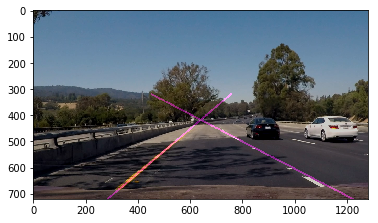

In [12]:
def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray,9)
    edges = canny(blur_gray, 50, 150) #low threshold = 40, 3:1 ratio

    #plt.imshow(edges, cmap = 'gray')
    imshape = image.shape

    #Define Polygon to select area of interest
    vertices = np.array([[(280,620),(610, 450), (700, 450), (1170,620)]],dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #Perform Hough Transform and draw onto lines of a blank image
    lines = hough_lines(masked_edges, 1, np.pi/180, 30, 10, 10)
    weight = weighted_img(lines, image)
    # you should return the final output (image where lines are drawn on lanes)
    plt.imshow(weight)
    return weight

challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))